# SWE Results: introductory examples

In this notebook we analyse the FEM discretisation used in our paper _Exploring Model Misspecification in Shallow Water Equations via Statistical Finite Elements_. The results of this notebook appear in brief in the appendix of the paper.

If you see anything of interest or have any questions, please do get in touch (cpd32 `at` cam.ac.uk).

In [1]:
import h5py

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from multiprocessing import Pool
from tqdm import tqdm

import sys
sys.path.insert(0, "../src")
from swe import ShallowOne, ShallowOneLinear
from figures import figure_sizes

fe.set_log_level(40)

In [2]:
dt = 1.
theta = 0.6

nu = 1.
bump_centre = 1000.

def run_model(nx):
    t_final = 10 * 60.
    nt = np.int32(t_final // dt)

    swe = ShallowOne(
        control=dict(nx=nx, dt=dt, theta=theta, simulation="tidal_flow"),
        params=dict(nu=5., shore_start=2000., shore_height=5.,
                    bump_height=0., bump_centre=8000., bump_width=400))
    
    t = 0.
    for i in range(nt):
        t += swe.dt
        swe.solve(t)
    
    return swe.du.vector().get_local()


def compute_error(du, du_ref):
    u, _ = du.split()
    u_ref, _ = du_ref.split()
    return fe.errornorm(u_ref, u)

In [3]:
nx_ref = 3000
swe_reference_dofs = run_model(nx_ref)

swe = ShallowOne(
    control=dict(nx=nx_ref, dt=dt, theta=theta, simulation="tidal_flow"),
    params=dict(nu=5., shore_start=2000., shore_height=5.,
                bump_height=0., bump_centre=8000., bump_width=400))

du_ref = swe.du.copy()
du_ref.vector().set_local(swe_reference_dofs)

In [4]:
nx = [500, 600, 750, 1000, 1500]

p = Pool(8)
du_dofs = p.map(run_model, nx)

In [5]:
print(du_dofs)
dus = []
for n, du_dof in zip(nx, du_dofs):
    swe = ShallowOne(
        control=dict(nx=n, dt=dt, theta=0.6, simulation="tidal_flow"),
        params=dict(nu=5., shore_start=2000., shore_height=5.,
                    bump_height=0., bump_centre=8000., bump_width=400))
    du = swe.du.copy()
    du.vector().set_local(du_dof)
    dus.append(du)

[array([0.        , 0.04469032, 0.06955049, ..., 1.86264555, 1.8622754 ,
       3.9923894 ]), array([0.        , 0.03295757, 0.06139409, ..., 1.86230813, 1.86209258,
       3.9923894 ]), array([0.        , 0.02391207, 0.0551407 , ..., 1.86204066, 1.86193867,
       3.9923894 ]), array([0.        , 0.0167521 , 0.05064771, ..., 1.86184068, 1.86181365,
       3.9923894 ]), array([0.        , 0.01072749, 0.04768786, ..., 1.86169696, 1.86170921,
       3.9923894 ])]


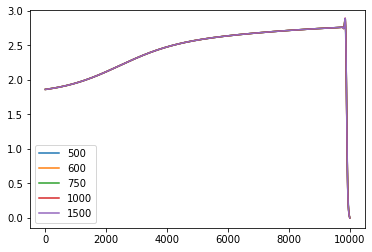

In [6]:
for du in dus:
    u, h = du.split()
    fe.plot(u)

plt.legend(nx)
plt.show()

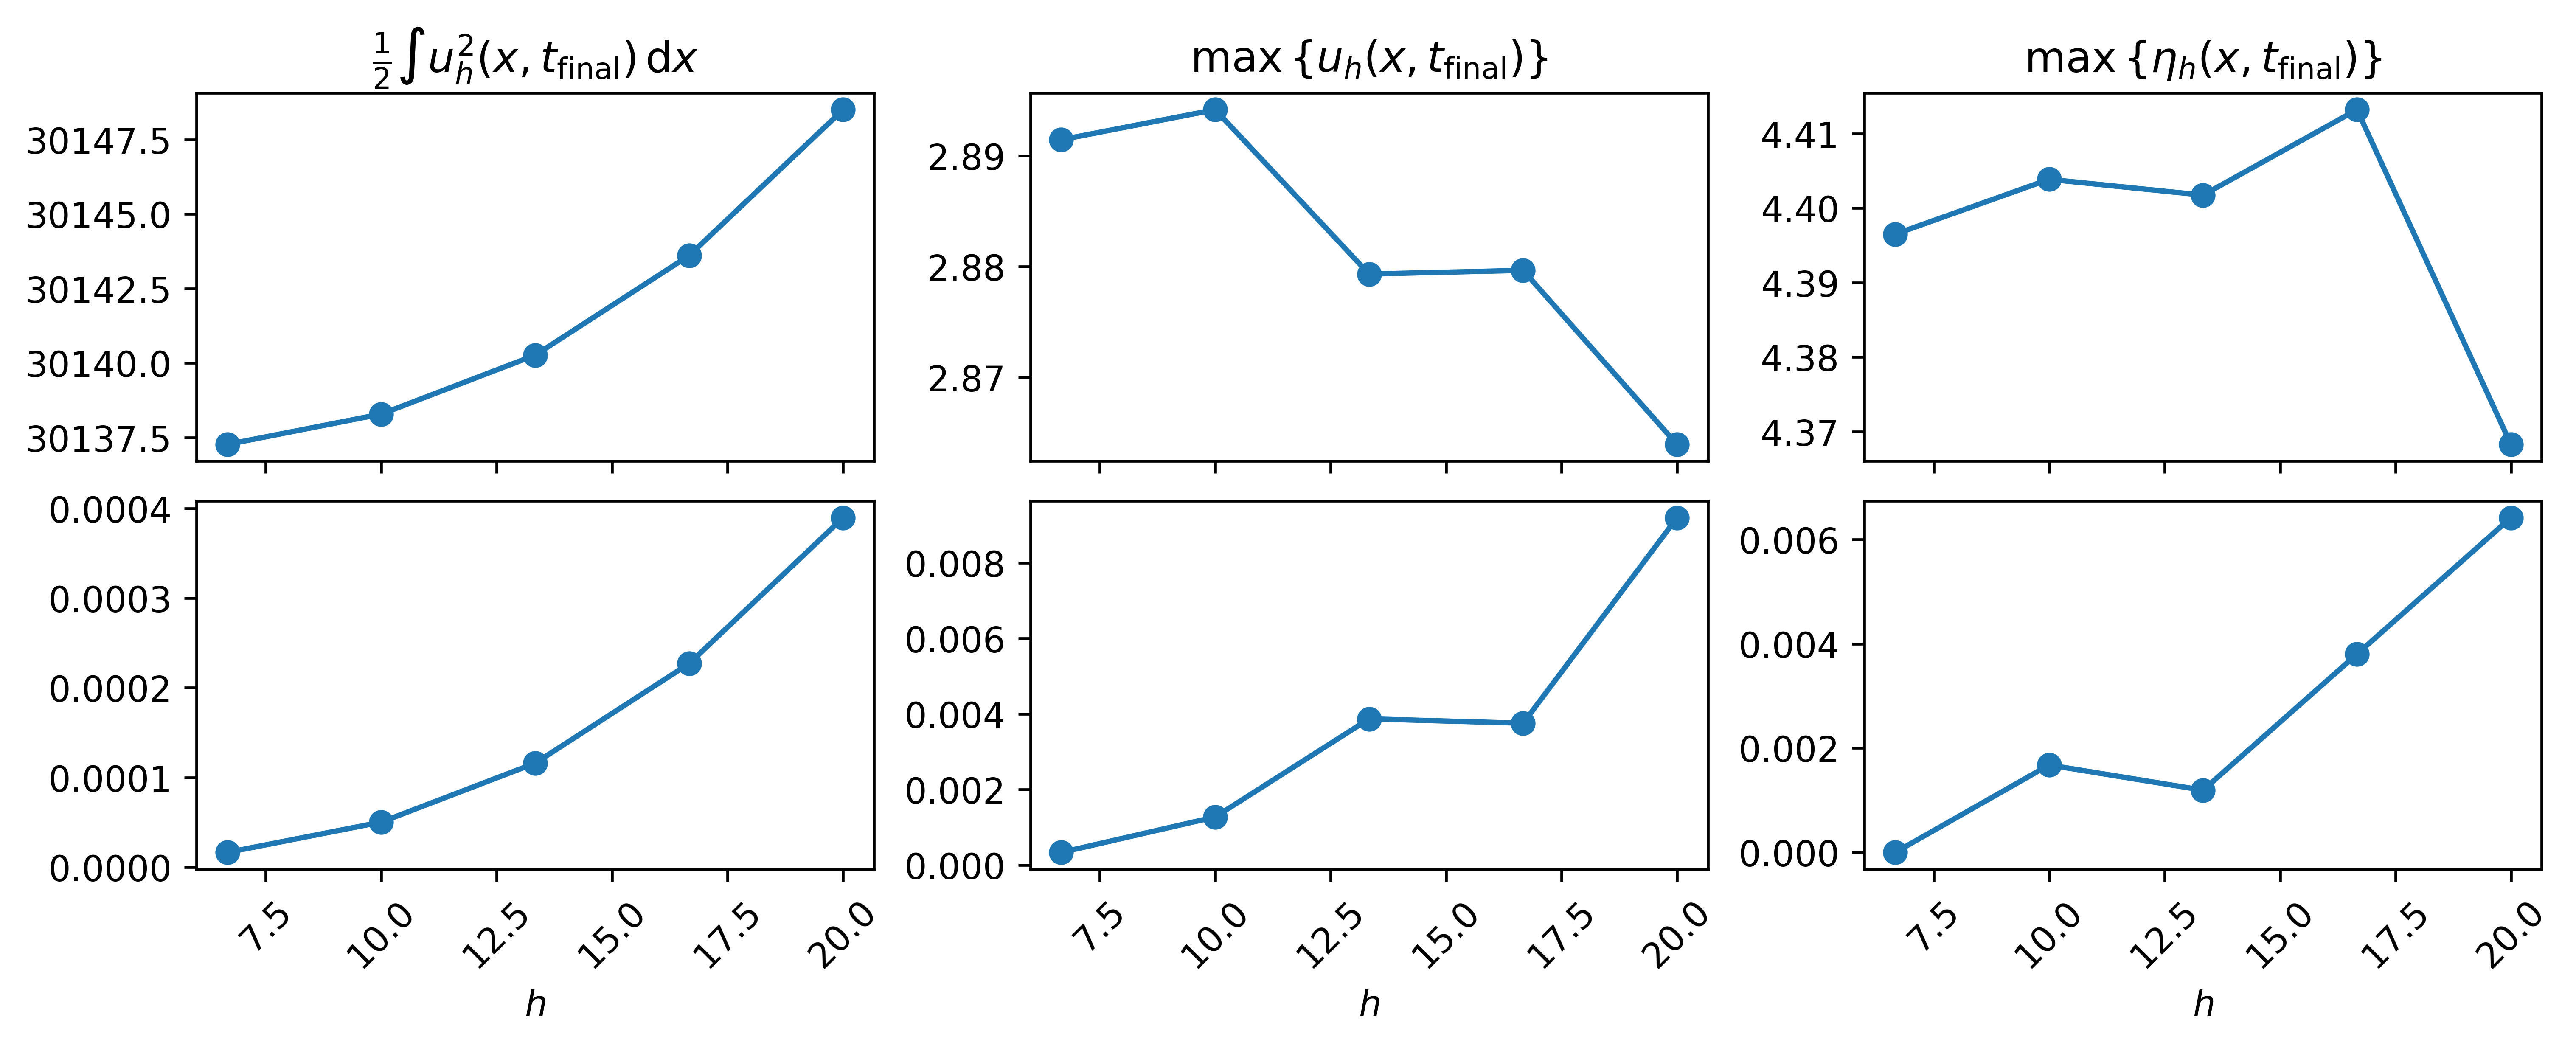

In [7]:
h_grid = np.array([10_000 / n for n in nx])

energies = np.zeros_like(nx, dtype=np.float64)
u_max = np.zeros_like(nx, dtype=np.float64)
h_max = np.zeros_like(nx, dtype=np.float64)

for i, du in enumerate(dus):
    u, h = du.split()
    
    u_max[i] = np.max(u.compute_vertex_values())
    h_max[i] = np.max(h.compute_vertex_values())
    energies[i] = fe.assemble(0.5 * u**2 * fe.dx)

u_ref, h_ref = du_ref.split()
energy_ref = fe.assemble(0.5 * u_ref**2 * fe.dx)
u_max_ref = np.max(u_ref.compute_vertex_values())
h_max_ref = np.max(h.compute_vertex_values())

fig, ax = plt.subplots(2, 3, constrained_layout=True,
                       figsize=(10, 4), sharex=True, dpi=600)
ax = ax.flatten()
for a in ax:
    a.tick_params(axis='x', labelrotation=45)

ax[0].plot(h_grid, energies, "o-")
ax[0].set_title(r"$\frac{1}{2} \int u_h^2(x, t_{\mathrm{final}}) \, \mathrm{d} x $")
ax[1].plot(h_grid, u_max, "o-")
ax[1].set_title(r"$\max \, \{u_h(x, t_{\mathrm{final}})\}$")
ax[2].plot(h_grid, h_max, "o-")
ax[2].set_title(r"$\max \, \{\eta_h(x, t_{\mathrm{final}})\}$")

ax[3].plot(h_grid, np.abs(energies - energy_ref) / np.abs(energy_ref), "o-")
ax[4].plot(h_grid, np.abs(u_max - u_max_ref) / np.abs(u_max_ref), "o-")
ax[5].plot(h_grid, np.abs(h_max - h_max_ref) / np.abs(h_max_ref), "o-")

for ax in ax[3:]:
    ax.set_xlabel(r"$h$")

plt.savefig("../figures/fem-mesh-refinement-convergence.pdf")
plt.show()

In [8]:
errors = np.array([compute_error(du, du_ref) for du in dus])

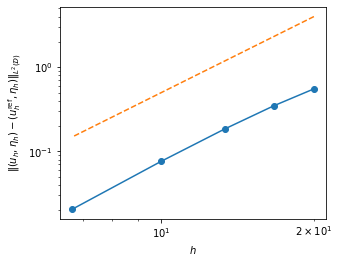

In [9]:
fig, ax = plt.subplots(1, 1, 
                       constrained_layout=True, 
                       figsize=(1.3 * figure_sizes["halfwidth"], 
                                1 * figure_sizes["halfwidth"]))
ax.loglog(h_grid, errors, marker="o")
ax.loglog(h_grid, 5e-4 * h_grid**3, "--")
ax.set_xlabel(r"$h$")
ax.set_ylabel(r"$\Vert (u_h, \eta_h) - (u_h^{\mathrm{ref}}, \eta_h) \Vert_{L^2(\mathcal{D})} $")
plt.savefig("../figures/fem-convergence.pdf")

In [10]:
from scipy.stats import linregress
print(linregress(np.log(h_grid), np.log(errors)))

LinregressResult(slope=3.014392943582383, intercept=-9.55403061947638, rvalue=0.9990849822098915, pvalue=3.3221447184805434e-05, stderr=0.07450187510300173, intercept_stderr=0.18994366089014408)
